# Trabajo Práctico N° 1 - Minería de Datos

**Año:** 2024  
**Materia:** Minería de Datos  
**Integrantes:** Avecilla Tomás, Calcia Franco

A lo largo de este trabajo práctico, hemos integrado y aplicado varias técnicas de minería de datos para analizar y visualizar un conjunto de datos relacionado con los cultivos. Cada técnica nos ha ofrecido perspectivas únicas y complementarias, permitiéndonos obtener una comprensión más profunda de los datos y sus estructuras subyacentes.

Esperamos que este análisis contribuya a una mejor comprensión de cómo las técnicas de minería de datos pueden aplicarse a problemas reales y a la toma de decisiones en el campo de la agricultura.


### Diccionario de Datos

Utilizaremos el archivo `dxCropRecommendation.csv` como base para nuestro análisis. Este conjunto de datos, disponible en [Kaggle](https://www.kaggle.com/datasets/chitrakumari25/smart-agricultural-production-optimizing-engine), contiene información clave sobre diversos cultivos, permitiéndonos investigar y aplicar técnicas de minería de datos para optimizar la producción agrícola.

| Columna        | Tipo       | Descripción                                                                                           |
|----------------|------------|-------------------------------------------------------------------------------------------------------|
| **Nitrogeno**   | `int64`    | Cantidad de nitrógeno en el suelo.                                  |
| **Fosforo**     | `int64`    | Cantidad de fósforo en el suelo.                                    |
| **Potasio**     | `int64`    | Cantidad de potasio en el suelo.                                    |
| **Temperatura** | `float64`  | Temperatura del suelo en grados Celsius.                                                               |
| **Humedad**     | `float64`  | Porcentaje de humedad presente en el suelo.                                                            |
| **pH**          | `float64`  | Medida de acidez o alcalinidad del suelo; valores bajos indican acidez y altos alcalinidad.            |
| **Lluvia**      | `float64`  | Cantidad de precipitaciónes.                                                          |
| **Cultivo**     | `category` | Tipo de cultivo.              |


# Preparacion del entorno de trabajo

In [ ]:
!pip install gdown
!pip install gap-stat==1.0.0
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from gap_statistic import OptimalK
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, silhouette_samples
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import lil_matrix

In [ ]:
!gdown "1X3wLgsHQ6O4lnspEcsYmMv7WlwjSfrnB" --output "dxCropRecommendation.csv"

Downloading...
From: https://drive.google.com/uc?id=1X3wLgsHQ6O4lnspEcsYmMv7WlwjSfrnB
To: /content/dxCropRecommendation.csv
100% 107k/107k [00:00<00:00, 75.2MB/s]


In [ ]:
df_cultivos = pd.read_csv('dxCropRecommendation.csv')
df_frutas = df_cultivos.copy()

#Analisis exploratorio

## Analisis Descriptivo

In [ ]:
df_cultivos.head()

,Nitrogeno,Fosforo,Potasio,Temperatura,Humedad,pH,Lluvia,Cultivo
0,90,42,43,20.879744,82.002744,6.502985,202.935536,Arroz
1,85,58,41,21.770462,80.319644,7.038096,226.655537,Arroz
2,60,55,44,23.004459,82.320763,7.840207,263.964248,Arroz
3,74,35,40,26.491096,80.158363,6.980401,242.864034,Arroz
4,78,42,42,20.130175,81.604873,7.628473,262.717340,Arroz


In [ ]:
df_cultivos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nitrogeno    1600 non-null   int64  
 1   Fosforo      1600 non-null   int64  
 2   Potasio      1600 non-null   int64  
 3   Temperatura  1600 non-null   float64
 4   Humedad      1600 non-null   float64
 5   pH           1600 non-null   float64
 6   Lluvia       1600 non-null   float64
 7   Cultivo      1600 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 100.1+ KB


In [ ]:
df_cultivos.isnull().sum()

,0
Nitrogeno,0
Fosforo,0
Potasio,0
Temperatura,0
Humedad,0
pH,0
Lluvia,0
Cultivo,0


- Notamos que la columna **Cultivo** estaba en tipo `object` y decidimos modificarla para que sea una categoría.
- Notamos, además, que no hay valores nulos, por lo cual no es necesario hacer un tratado.

In [ ]:
df_cultivos["Cultivo"] = df_cultivos["Cultivo"].astype('category')

### Manejo de Valores Atipicos

Optamos por un boxplot para ver la distribución de los datos.

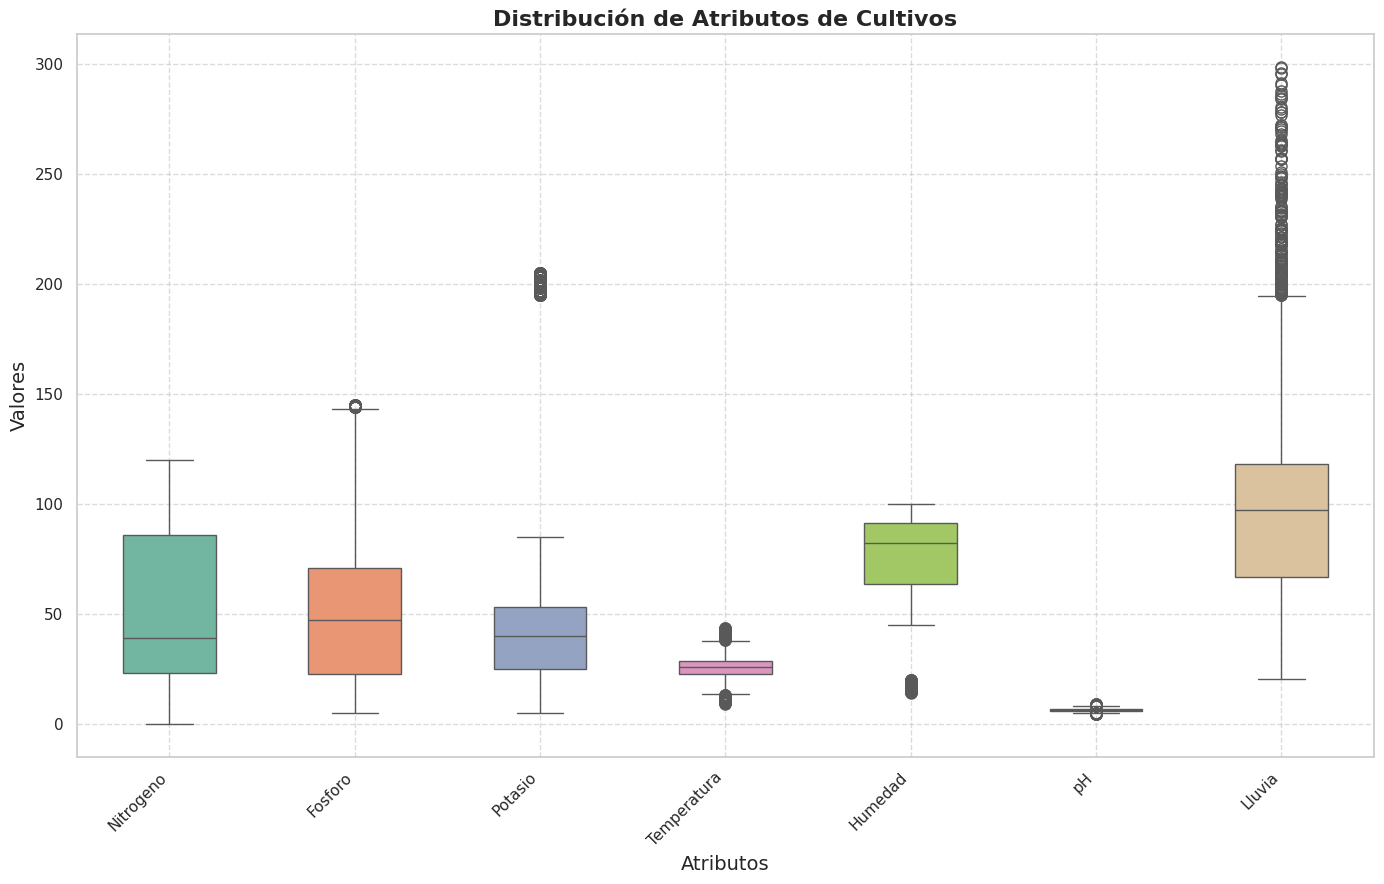

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 9))
boxplot = sns.boxplot(data=df_cultivos, palette="Set2", width=0.5, fliersize=8)

plt.title('Distribución de Atributos de Cultivos', fontsize=16, fontweight='bold')
plt.xlabel('Atributos', fontsize=14)
plt.ylabel('Valores', fontsize=14)

plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)

for i, artist in enumerate(boxplot.artists):
    for line in artist.get_lines():
        line.set_color('black')
        line.set_linewidth(1.5)

plt.tight_layout()
plt.show()


Ya que podemos observar varios puntos fuera de los bigotes en algunos boxplots, decidimos hacer un analisis mas profundo...

In [ ]:
resultados_atipicos = {}

for columna in df_cultivos.columns:
    if df_cultivos[columna].dtype in ['int64', 'float64']:
        Q1 = df_cultivos[columna].quantile(0.25)
        Q3 = df_cultivos[columna].quantile(0.75)
        IQR = Q3 - Q1

        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        es_atipico = (df_cultivos[columna] < limite_inferior) | (df_cultivos[columna] > limite_superior)

        cantidad_atipicos = es_atipico.sum()
        porcentaje_atipicos = (cantidad_atipicos / len(df_cultivos)) * 100

        resultados_atipicos[columna] = porcentaje_atipicos

for columna, porcentaje in resultados_atipicos.items():
    print(f"Columna: {columna} - Porcentaje de valores atípicos: {porcentaje:.2f}%")


Columna: Nitrogeno - Porcentaje de valores atípicos: 0.00%
Columna: Fosforo - Porcentaje de valores atípicos: 1.25%
Columna: Potasio - Porcentaje de valores atípicos: 12.50%
Columna: Temperatura - Porcentaje de valores atípicos: 4.94%
Columna: Humedad - Porcentaje de valores atípicos: 6.25%
Columna: pH - Porcentaje de valores atípicos: 1.88%
Columna: Lluvia - Porcentaje de valores atípicos: 9.50%


Podríamos continuar con el manejo de outliers, al menos en ciertas columnas que presentan un porcentaje significativo, ya que estos podrían generar problemas al aplicar técnicas de reducción de dimensionalidad. Sin embargo, antes de eso, decidimos analizar de forma más localizada.

In [ ]:
multiplo_iqr = 3

grupos = df_cultivos.groupby('Cultivo', observed=True)

resultados_atipicos_local = {}

# Iterar sobre cada grupo (cultivo)
for cultivo, df_cultivo in grupos:
    resultados_atipicos_local[cultivo] = {}

    # Iterar sobre cada columna numérica del DataFrame
    for columna in df_cultivo.select_dtypes(include=['int64', 'float64']).columns:
        Q1 = df_cultivo[columna].quantile(0.25)
        Q3 = df_cultivo[columna].quantile(0.75)
        IQR = Q3 - Q1

        limite_inferior = Q1 - multiplo_iqr * IQR
        limite_superior = Q3 + multiplo_iqr * IQR

        es_atipico = (df_cultivo[columna] < limite_inferior) | (df_cultivo[columna] > limite_superior)

        cantidad_atipicos = es_atipico.sum()

        if columna in resultados_atipicos_local[cultivo]:
            resultados_atipicos_local[cultivo][columna] += cantidad_atipicos
        else:
            resultados_atipicos_local[cultivo][columna] = cantidad_atipicos

# Convertir el diccionario en un DataFrame para un resumen más claro
df_resultados = pd.DataFrame(resultados_atipicos_local).T  # Transponer para tener cultivos como filas

# Calcular la cantidad total de valores atípicos por cultivo
df_resultados['Total Atípicos'] = df_resultados.sum(axis=1)

# Mostrar el DataFrame resumido
print("Resumen de valores atípicos por cultivo y columna:")
print(df_resultados)
print("\nResumen de valores atípicos por cultivo (cantidad total):")
print(df_resultados[['Total Atípicos']])

Resumen de valores atípicos por cultivo y columna:
            Nitrogeno  Fosforo  Potasio  Temperatura  Humedad  pH  Lluvia  \
Arroz               0        0        0            0        0   0       0   
Banana              0        0        0            0        0   0       0   
Cafe                0        0        0            0        0   0       0   
Coco                0        0        0            0        0   0       0   
Garbanzo            0        0        0            0        0   0       0   
Granada             0        0        0            0        0   0       0   
GranoNegro          0        0        0            0        0   0       0   
Lenteja             0        0        0            0        0   0       0   
Maiz                0        0        0            0        0   0       0   
Mango               0        0        0            0        0   0       0   
Manzana             0        0        0            0        0   0       0   
Melon               0    


Al parecer, si separamos el dataframe por cultivos, no encontramos ningún valor atípico. Esto nos lleva a la decisión de considerarlos como parte de la información relevante del dataset y no tratarlos de ninguna manera.

### Matriz de correlacion

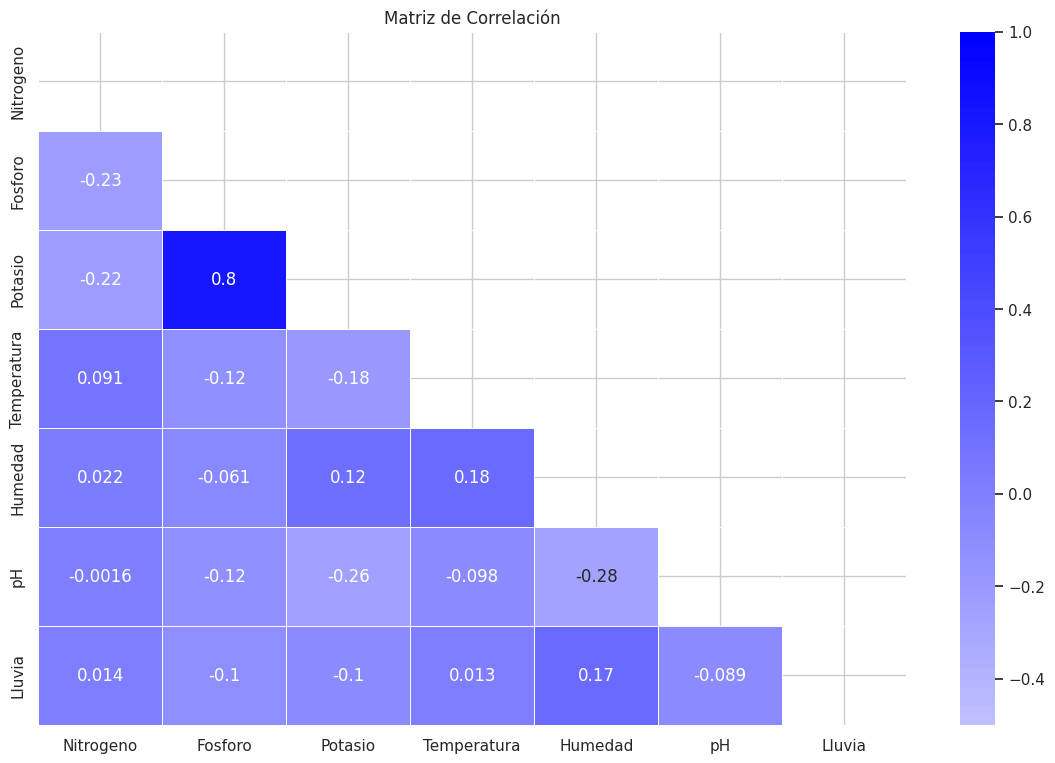

In [ ]:
df_sub = df_cultivos.drop(["Cultivo"], axis = 1)
corr = df_sub.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

colors = [(1, 1, 1), (0, 0, 1)]  # Blanco a rojo
n_bins = 100
cmap_name = 'Blues'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

plt.figure(figsize=(14, 9))
sns.heatmap(corr, mask=mask, annot=True, cmap=cm, center=0, vmin=-0.5, vmax=1, linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()


Podemos notar una fuerte relacion entre el fosforo y el potasio (.8) por lo cual es pertinente indagar en esto...

#### Relación Fosforo - Potasio

In [ ]:
correlaciones_por_cultivo = {}
for cultivo, df_cultivo in grupos:
    # Calcular la correlación entre fósforo y potasio para el cultivo actual
    correlacion = df_cultivo[['Fosforo', 'Potasio']].corr().iloc[0, 1]
    correlaciones_por_cultivo[cultivo] = correlacion
df_correlaciones = pd.DataFrame(list(correlaciones_por_cultivo.items()), columns=['Cultivo', 'Correlación Fosforo-Potasio'])

print("Correlación entre Fósforo y Potasio por Cultivo:")
print(df_correlaciones)



Correlación entre Fósforo y Potasio por Cultivo:
       Cultivo  Correlación Fosforo-Potasio
0        Arroz                    -0.011042
1       Banana                     0.085407
2         Cafe                     0.241338
3         Coco                    -0.068872
4     Garbanzo                    -0.037861
5      Granada                    -0.118911
6   GranoNegro                    -0.028036
7      Lenteja                    -0.144171
8         Maiz                    -0.008899
9        Mango                    -0.033436
10     Manzana                    -0.164638
11       Melon                     0.131986
12     Naranja                     0.105884
13      Papaya                     0.035026
14      Sandia                     0.070209
15         Uva                     0.106839


- No se encontró una relación significativa entre fósforo y potasio cuando se separó por cultivo.
- Aunque hay una alta correlación global (0.8) entre fósforo y potasio, no hay redundancia clara a nivel de cultivo. Eliminar una de estas columnas podría llevar a la pérdida de información relevante.

Teniendo en cuenta lo concluido decidimos continuar.


# Estandarización

Decidimos utilizar el `RobustScaler` para este análisis, dado que anteriormente optamos por mantener los valores atípicos en el conjunto de datos. Aunque estos valores atípicos no se presentan de manera significativa a nivel local, su presencia global podría influir en las técnicas posteriores de reducción de dimensionalidad. El `RobustScaler` es adecuado en este contexto porque escala los datos de manera robusta frente a valores atípicos, lo que ayuda a mitigar su impacto en el análisis subsiguiente.


In [ ]:
scaler = RobustScaler()
df_scaled = scaler.fit_transform(df_cultivos.drop(["Cultivo"], axis = 1))

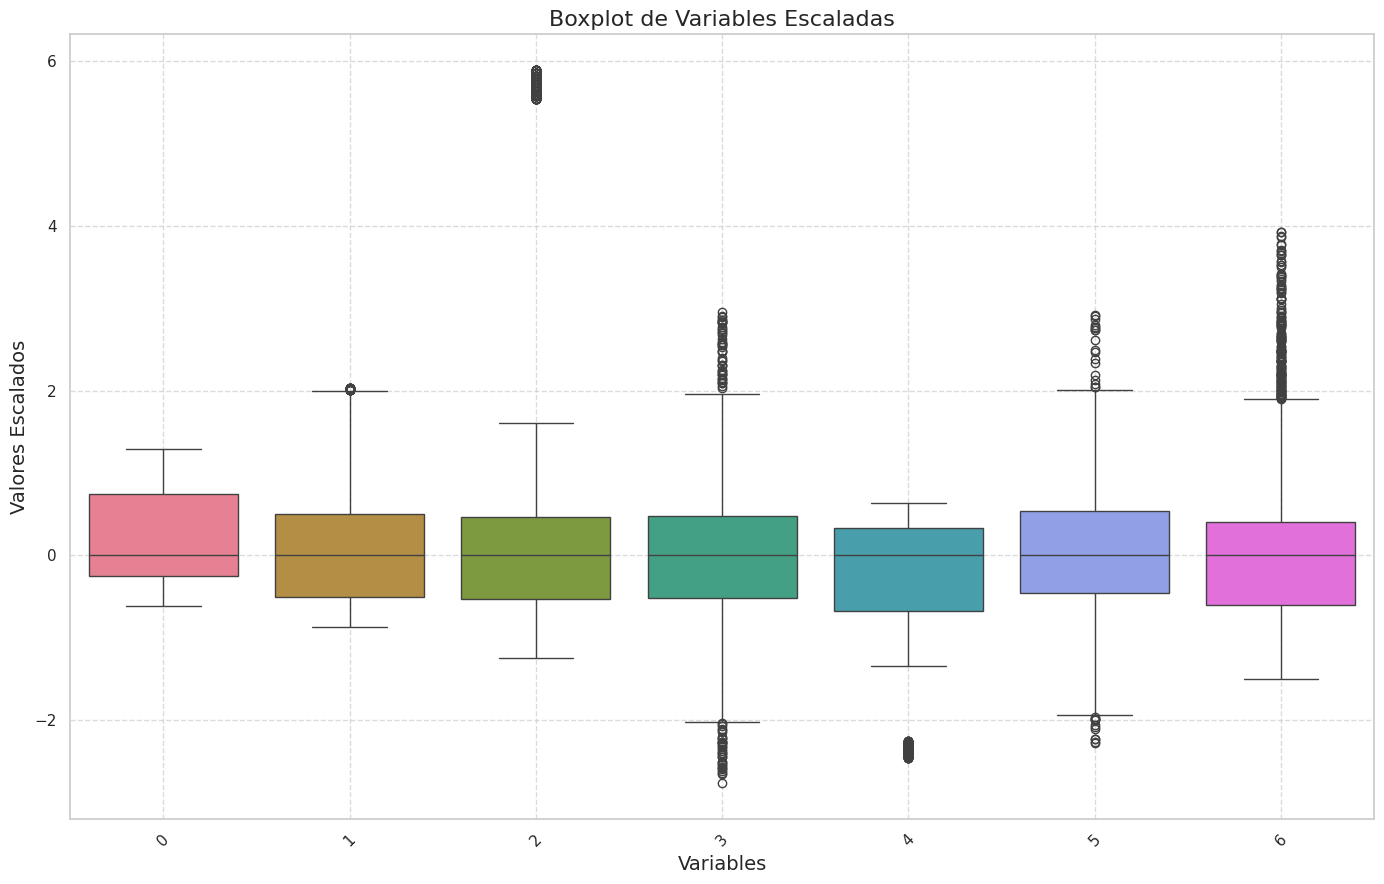

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 9))

sns.boxplot(data=df_scaled, palette="husl")

plt.title('Boxplot de Variables Escaladas', fontsize=16)
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Valores Escalados', fontsize=14)

plt.xticks(rotation=45)

plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Técnicas de Reducción de Dimensionalidad

## PCA

### Selección de Componentes Principales

In [ ]:
pca = PCA(n_components=df_sub.shape[1], random_state=0)
pca_features = pca.fit_transform(df_scaled)

pca_df = pd.DataFrame(
    data=pca_features,
    columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'])
pca_df['Cultivo'] = df_cultivos['Cultivo']

In [ ]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,Cultivo
0,-0.647800,1.768621,-1.028353,-0.272211,0.136003,0.600950,0.099944,Arroz
1,-0.718599,2.044651,-1.331954,0.415743,0.398772,0.568798,0.324860,Arroz
2,-0.771011,2.558978,-1.733904,1.267206,1.014611,0.283823,0.104709,Arroz
3,-0.967201,2.436948,-0.770022,0.778422,0.332993,0.414699,-0.198693,Arroz
4,-0.871836,2.547426,-1.981154,0.743941,0.909130,0.555920,-0.024962,Arroz
...,...,...,...,...,...,...,...,...
1595,-1.190448,1.166006,-0.444839,0.530891,-0.134388,0.886465,-0.149936,Cafe
1596,-1.345090,0.356877,0.098966,-0.083419,-0.821641,0.692846,-0.475563,Cafe
1597,-1.180454,1.158926,-0.551036,-0.082936,-0.388459,1.009871,-0.038524,Cafe
1598,-1.091701,0.111920,-0.407306,0.450137,-0.456244,1.061598,-0.283808,Cafe


In [ ]:
pd.DataFrame(pca.components_, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'], index=['Nitrogeno', 'Fosforo', 'Potasio', 'Temperatura', 'Humedad', 'pH', 'Lluvia'])

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Nitrogeno,-0.064071,0.305059,0.937701,-0.085937,0.039647,-0.101016,-0.066249
Fosforo,0.006078,-0.031787,0.050530,0.092201,0.264546,-0.217351,0.933098
Potasio,0.070024,-0.052761,0.017679,0.790993,0.378757,-0.381792,-0.277685
Temperatura,-0.076546,0.262429,0.060730,0.582965,-0.394927,0.619528,0.204823
Humedad,-0.010285,-0.147006,0.071255,-0.085932,0.748515,0.633504,-0.064958
pH,0.987282,-0.049813,0.097132,-0.007103,-0.074536,0.083508,0.027898
Lluvia,0.101309,0.900102,-0.315675,-0.105647,0.251373,-0.068360,-0.029654


In [ ]:
def acumular_varianza(numbers):
     sum = 0
     var_c = []
     for num in numbers:
        sum += num
        var_c.append(sum)
     return var_c

In [ ]:
var_c = acumular_varianza(pca.explained_variance_ratio_)
pca_rtd = pd.DataFrame({'Eigenvalues':pca.explained_variance_, 'Proporción de variancia explicada':pca.explained_variance_ratio_, 'Proporción acumulado de variancia explicada': var_c})
pca_rtd

,Eigenvalues,Proporción de variancia explicada,Proporción acumulado de variancia explicada
0,4.589615,0.562719,0.562719
1,1.253512,0.153689,0.716408
2,0.869099,0.106558,0.822965
3,0.556781,0.068265,0.891231
4,0.414192,0.050783,0.942013
5,0.300442,0.036836,0.978850
6,0.172506,0.021150,1.000000


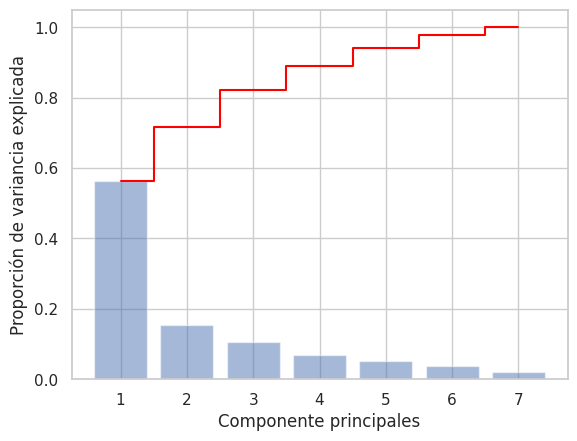

In [ ]:
plt.bar(range(1,8), pca.explained_variance_ratio_,
        alpha=0.5,
        align='center')
plt.step(range(1,8), np.cumsum(pca.explained_variance_ratio_),
         where='mid',
         color='red')
plt.ylabel('Proporción de variancia explicada')
plt.xlabel('Componente principales')
plt.show()

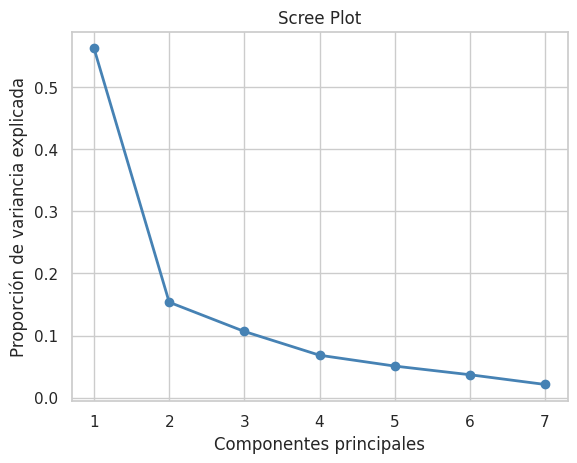

In [ ]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='steelblue')
plt.title('Scree Plot')
plt.xlabel('Componentes principales')
plt.ylabel('Proporción de variancia explicada')
plt.show()

### 2 Componentes Principales

Optamos por utilizar solo 2 componentes principales debido a los siguientes motivos:

1. **Captura Significativa de Varianza**: Los dos primeros componentes explican el 71.64% de la variabilidad total en los datos, lo cual es sustancial.

3. **Ley del Codo**: La ganancia en varianza explicada disminuye significativamente después del segundo componente.


### Matriz de correlacion de PC seleccionados

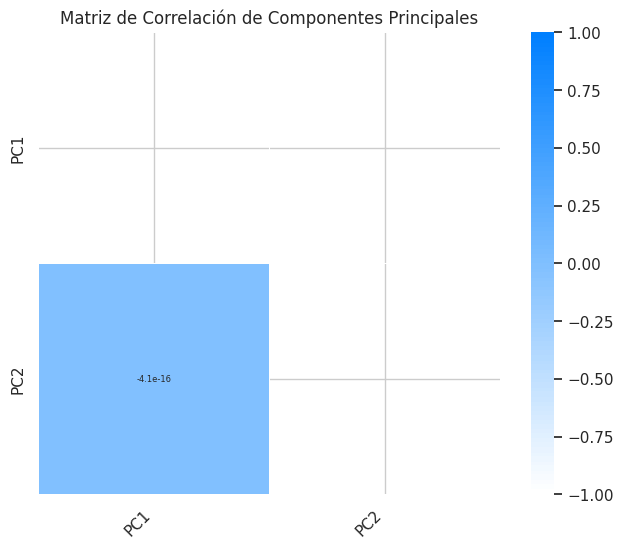

In [ ]:
corr = pca_df[['PC1', 'PC2']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
colors = [(1, 1, 1), (0, 0.5, 1)]
n_bins = 100
cmap_name = 'blue_white'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    corr,
    mask=mask,
    vmin=-1, vmax=1, center=0,
    cmap=cm,
    square=True,
    annot=True,
    annot_kws={'size': 6},
    linewidths=0.5
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.title('Matriz de Correlación de Componentes Principales')
plt.show()


Verificamos que las componentes principales no estan correlacionadas y esto esta bien ya que son ortogonales entre si.

### Visualización PCA

In [ ]:
features = df_cultivos.drop(columns=['Cultivo']).columns.to_list()

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
fig = px.scatter(pca_features, x=0, y=1, color = pca_df["Cultivo"],  labels={'color': 'Cultivo'})
for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0]*4.5,
        y1=loadings[i, 1]*4.5
    )
    fig.add_annotation(
        x=loadings[i, 0]*5.5,
        y=loadings[i, 1]*5.5,
        ax=0, ay=0,
        xanchor='center',
        yanchor='bottom',
        text=feature,
    )
fig.update_layout(title = "Biplot",width = 1200,height = 600)
fig.show()


**Biplot**:
- Agrupaciones de cultivos:

Hay agrupaciones claras de algunos cultivos. Por ejemplo, "Manzana" y "Uva" están muy separados a la derecha, lo que indica que estos cultivos tienen características muy diferentes en relación con las variables del gráfico.
En cambio, cultivos como "Maíz", "Garbanzo", y "Lenteja" parecen estar más agrupados en el lado izquierdo, lo que sugiere que comparten condiciones similares en cuanto a las variables ambientales.
- Relación entre cultivos y variables:

"Coco" está fuertemente influenciado por el Potasio, dado que está en la dirección de la flecha.
"Lluvia" parece ser una variable más importante para los cultivos en el extremo superior izquierdo.
"Temperatura" y "Nitrógeno" afectan a varios cultivos cerca del centro del gráfico, sugiriendo que estos factores son comunes en muchos de los cultivos representados.
- Longitud de las flechas:

La longitud de las flechas indica la magnitud o peso que tiene cada variable sobre las observaciones (cultivos). Por ejemplo:
"Potasio" tiene una flecha larga que se extiende hacia la derecha, lo que significa que tiene un efecto fuerte sobre los cultivos en esa dirección.
Variables como "pH" y "Fósforo" tienen flechas más cortas, lo que indica que su influencia es menor en la variación total de los datos.

## ISOMAP

#### 3 Componentes

In [ ]:
isomap_df = Isomap(n_neighbors=350, n_components=3)
isomap_df.fit(df_scaled)
projections_isomap = isomap_df.transform(df_scaled)

fig = px.scatter_3d(
    projections_isomap, x=0, y=1, z=2,
    color=df_cultivos['Cultivo'], labels={'color': 'Cultivo'},
)

fig.update_traces(marker_size=5)
fig.show()

#### Análisis del Gráfico 3D de Cultivos y Decisión sobre Vecinos

La elección de 350 vecinos para Isomap afecta la forma en que se conectan los puntos y, por lo tanto, la estructura de los grupos. Usar un número elevado de vecinos es útil cuando para captar relaciones más amplias en el conjunto de datos. Sin embargo, reducir el número de vecinos podría revelar más detalles y patrones locales en los datos, mostrando separaciones más claras entre grupos de cultivos.
Consideramos que usar un numero mas elevado es mejor en este caso para captar grupos mas amplios.


### 5 componentes

In [ ]:
isomap_df = Isomap(n_neighbors=350, n_components=5)
isomap_df.fit(df_scaled)
projections_isomap = isomap_df.transform(df_scaled)

fig = px.scatter_3d(
    x=projections_isomap[:, 0],  # Primer componente
    y=projections_isomap[:, 1],  # Segundo componente
    z=projections_isomap[:, 2],  # Tercer componente
    color=df_cultivos['Cultivo'],
    labels={'color': 'Cultivo'},
    title="Isomap - Proyección en 3D"
)

fig.update_traces(marker=dict(size=5))
fig.show()


No observamos diferencias significativas al cambiar de 3 a 5 componentes. Esto puede indicar que se ha capturado la mayor parte de la estructura de los datos y que añadir más componentes solo introduce complejidad sin aportar valor añadido.

### 2 Componentes

In [ ]:
isomap_df_2d = Isomap(n_neighbors=350, n_components=2)
isomap_df_2d.fit(df_scaled)
projections_isomap_2d = isomap_df_2d.transform(df_scaled)

fig_2d = px.scatter(
    projections_isomap_2d, x=0, y=1,
    color=df_cultivos['Cultivo'], labels={'color': 'Cultivo'}
)
fig_2d.update_traces(marker_size=5)
fig_2d.show()


1. **Conservación de Grupos Definidos**:
   - Es positivo que los grupos de Uva y Manzana se mantengan bien definidos al reducir las dimensiones. Esto sugiere que estas características son robustas y claramente diferenciadas, lo que es útil para la identificación de estos cultivos.

2. **Superposición de Grupos**:
   - La superposición de otros cultivos indica que, al reducir las dimensiones, se pierde un poco de la información que diferenciaba a esos grupos. Esto puede reflejar similitudes en las características evaluadas, pero también puede hacer más difícil la identificación de patrones claros.
   - Es un buen punto mencionar que esto podría limitar la capacidad de tomar decisiones específicas sobre cultivos que tienen características más similares.

3. **Independencia del Garbanzo**:
   - El Garbanzo mantiene su independencia. Esto sugiere que tiene características únicas que lo separan de los otros cultivos, lo que podría ser valioso en ciertos analisis.

##### 10 Vecinos

In [ ]:
isomap_df_2d = Isomap(n_neighbors=10, n_components=2)
isomap_df_2d.fit(df_scaled)
projections_isomap_2d = isomap_df_2d.transform(df_scaled)

fig_2d = px.scatter(
    projections_isomap_2d, x=0, y=1,
    color=df_cultivos['Cultivo'], labels={'color': 'Cultivo'}
)
fig_2d.update_traces(marker_size=5)
fig_2d.show()


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_isomap.py:359: UserWarning:

The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more effi

Utilizar solo 10 vecinos en el algoritmo Isomap puede ser poco:
- Con un número tan bajo de vecinos, Isomap puede no ser capaz de captar adecuadamente la estructura global del espacio de datos. Esto puede llevar a que algunas relaciones importantes entre puntos de datos no se reflejen en el espacio reducido.

Aun asi podemos notar algunos patrones que habiamos visto como Lenteja y grano negro o la independencia del garbanzo pero aumentar el número de vecinos podría ayudar a mejorar la representación de las relaciones entre los cultivos, haciendo que los grupos sean más claros y fáciles de interpretar.

##### 1000 Vecinos

In [ ]:
isomap_df_2d = Isomap(n_neighbors=1000, n_components=2)
isomap_df_2d.fit(df_scaled)
projections_isomap_2d = isomap_df_2d.transform(df_scaled)

fig_2d = px.scatter(
    projections_isomap_2d, x=0, y=1,
    color=df_cultivos['Cultivo'], labels={'color': 'Cultivo'}
)
fig_2d.update_traces(marker_size=5)
fig_2d.show()


- Con un número más alto de vecinos, la estructura del espacio tiende a mantenerse más conectada, lo que puede resultar en menos variación local pero mayor coherencia global.
- Observamos que algunos cultivos aparecen más agrupados o mezclados debido a la inclusión de más vecinos en el cálculo de las distancias, lo cual suaviza las diferencias entre grupos, tal vez en exceso.

Aun así, destacamos las ya mencionadas Uva y Manzana, que se diferencian claramente del resto, y el Garbanzo, que sigue siendo visible.


Al variar el número de vecinos, podemos concluir que nos quedaríamos con un punto intermedio, como cuando se calculó con 350 vecinos, lo cual permitía observar numerosos patrones sin el problema de la gran superposición que surge al aumentar a 1000 vecinos.

## t-SNE

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



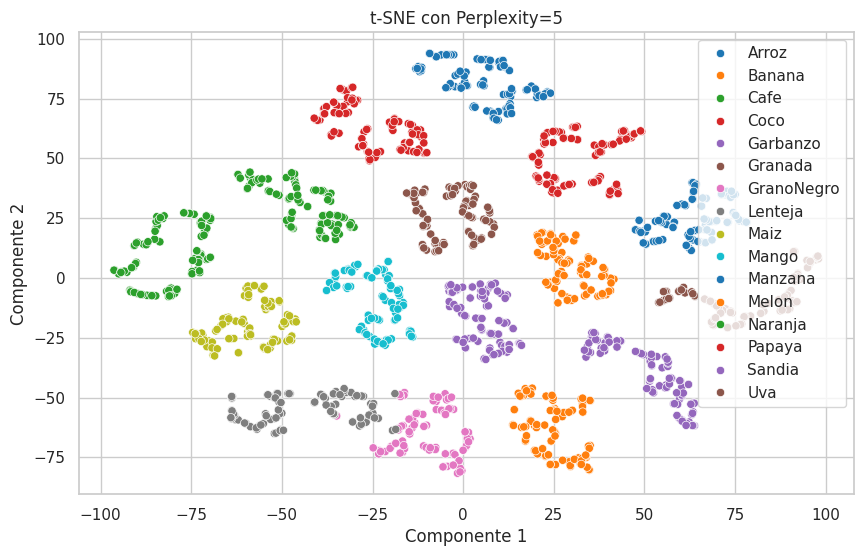

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



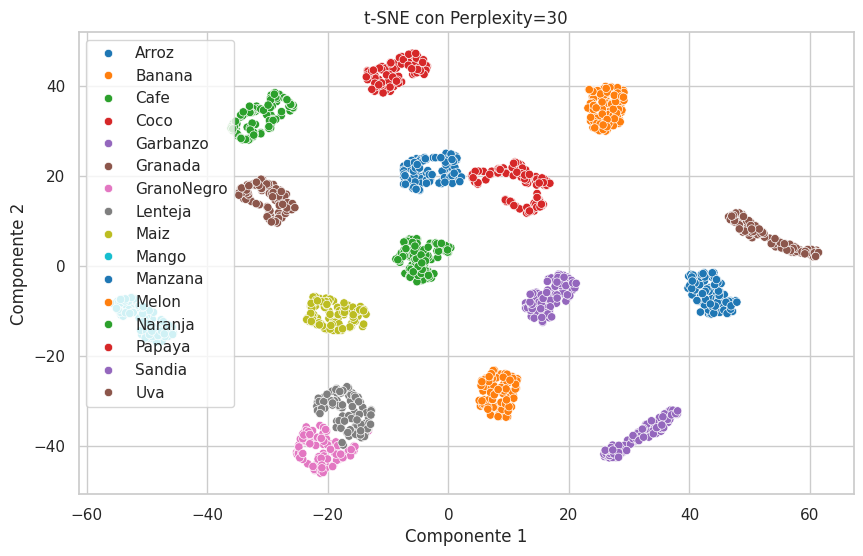

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



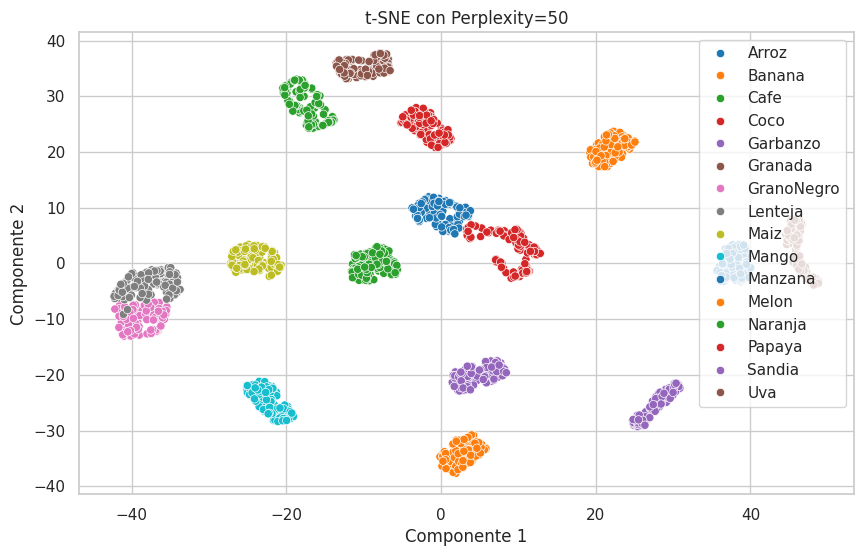

In [ ]:
perplexities = [5, 30, 50]
n_iter = 1000
n_components = 2

for perplexity in perplexities:
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter, random_state=42)
    X_tsne = tsne.fit_transform(df_scaled)

    df_tsne = pd.DataFrame(X_tsne, columns=['Component 1', 'Component 2'])
    df_tsne['Cultivo'] = df_cultivos['Cultivo']

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Component 1', y='Component 2', hue='Cultivo', data=df_tsne, palette='tab10')
    plt.title(f't-SNE con Perplexity={perplexity}')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.legend(loc='best')
    plt.show()


**Perplejidad Baja (5):** Muestra clusters muy definidos, pero con poca capacidad de generalización. Los puntos están muy agrupados.

**Perplejidad Moderada (30):** Ofrece un buen equilibrio entre la preservación de la estructura local y global. Los clusters son más claros y representativos.

**Perplejidad Alta (50):** Muestra una estructura más global y dispersa.

**Conclusión:** Dada la naturaleza de nuestro análisis y las decisiones tomadas, consideramos que deberíamos elegir un valor de perplejidad entre 10 y 30, ya que es importante resaltar la estructura local de los datos.


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



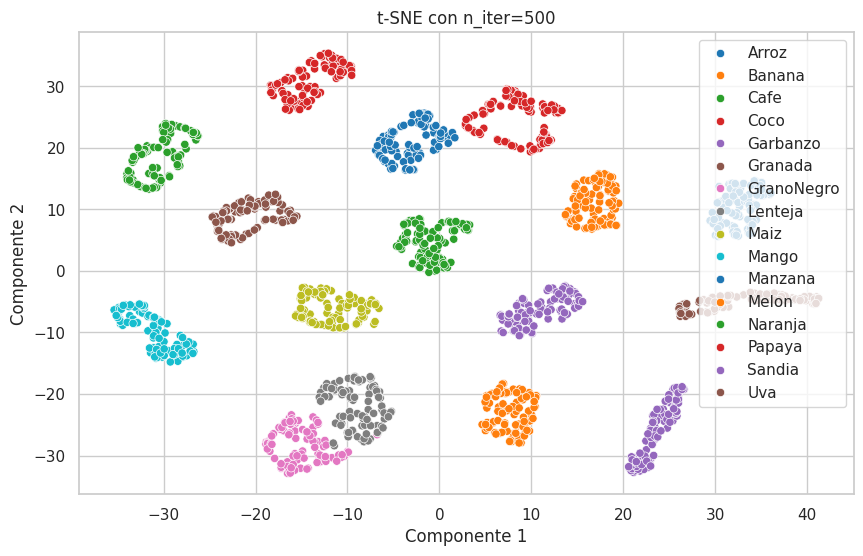

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



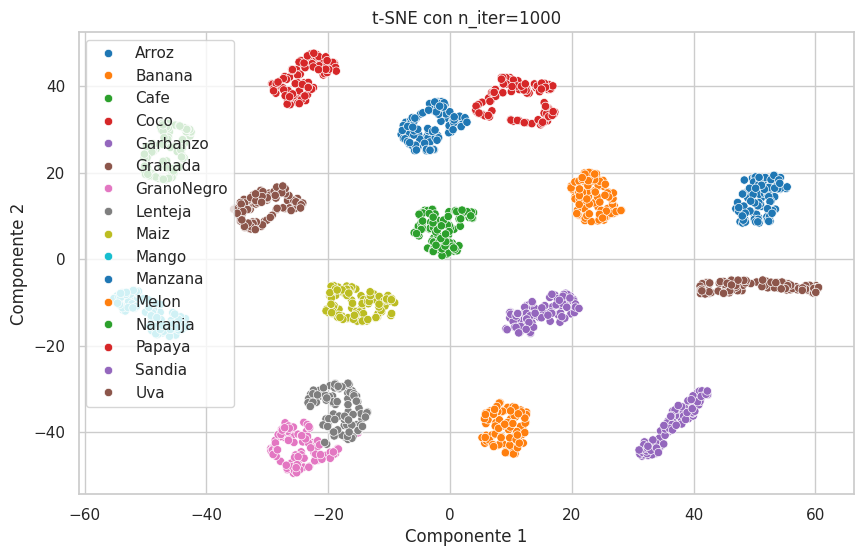

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



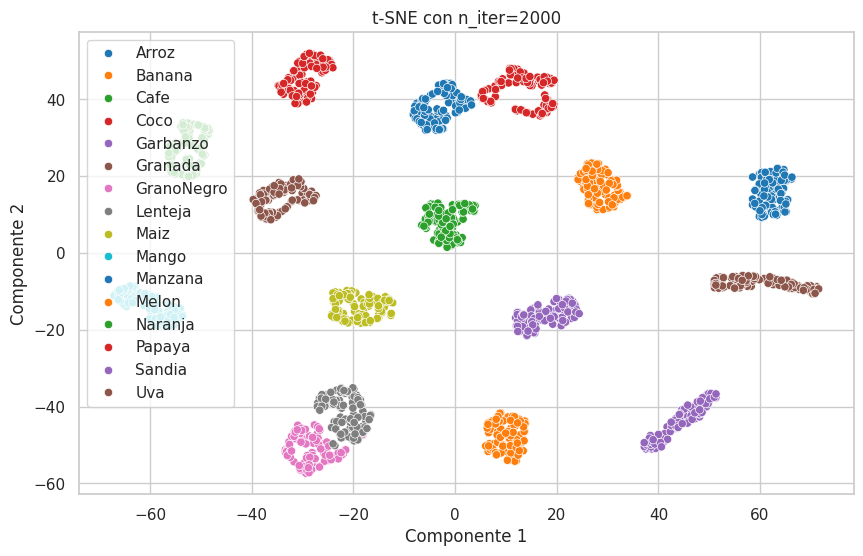

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



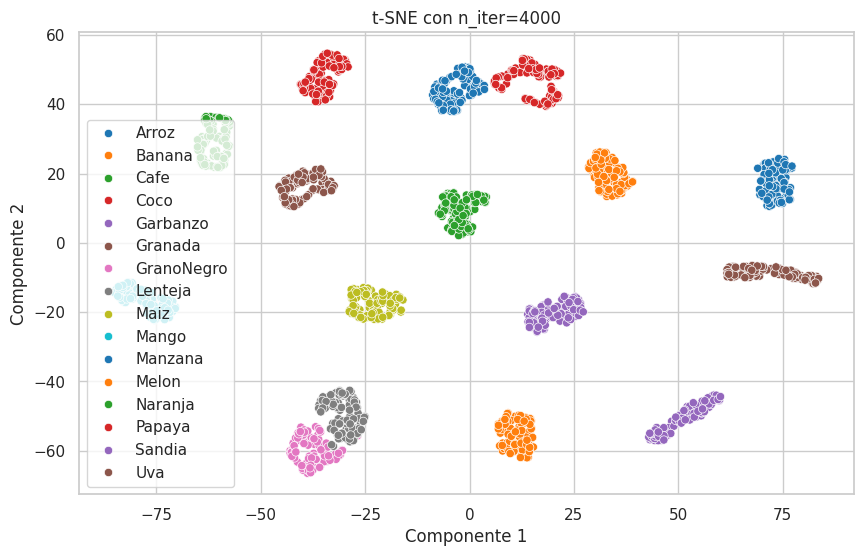

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



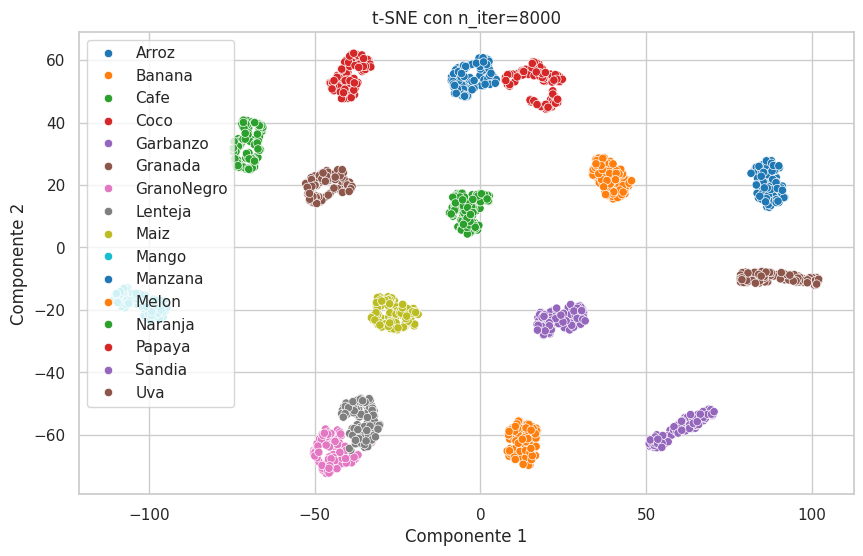

In [ ]:
n_iters = [500, 1000, 2000, 4000, 8000]

for n_iter in n_iters:
    tsne = TSNE(n_components=n_components, perplexity=25, n_iter=n_iter, random_state=42)
    X_tsne = tsne.fit_transform(df_scaled)

    df_tsne = pd.DataFrame(X_tsne, columns=['Component 1', 'Component 2'])
    df_tsne['Cultivo'] = df_cultivos['Cultivo']

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Component 1', y='Component 2', hue='Cultivo', data=df_tsne, palette='tab10')
    plt.title(f't-SNE con n_iter={n_iter}')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.legend(loc='best')
    plt.show()


- Aumentar el número de iteraciones mejora la estabilidad y precisión de la visualización. En este caso, observamos que a partir de las 2000 iteraciones, la visualización deja de cambiar significativamente.
- El tiempo de ejecución total fue de 2 minutos y medio, lo que muestra la alta exigencia computacional de incrementar el número de iteraciones.


# Subconjunto del Dataset

In [ ]:
frutas_seleccionadas = ["Granada", "Banana", "Mango", "Uva", "Sandia", "Melón", "Manzana", "Papaya", "Coco"]

## PCA de `df_frutas`

In [ ]:
df_frutas = df_frutas[df_frutas['Cultivo'].isin(frutas_seleccionadas)]
y = df_frutas['Cultivo']
X = df_frutas.drop(columns=['Cultivo'])

In [ ]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
pca = PCA(n_components=X_scaled.shape[1])
pca_features = pca.fit_transform(X_scaled)

var_c = acumular_varianza(pca.explained_variance_ratio_)

pca_rtd = pd.DataFrame({
    'Eigenvalues': pca.explained_variance_,
    'Proporción de variancia explicada': pca.explained_variance_ratio_,
    'Proporción acumulado de variancia explicada': var_c
})

print(pca_rtd)


   Eigenvalues  Proporción de variancia explicada  \
0     2.306258                           0.364739   
1     1.699014                           0.268702   
2     0.969836                           0.153381   
3     0.744361                           0.117722   
4     0.341294                           0.053976   
5     0.228518                           0.036141   
6     0.033761                           0.005339   

   Proporción acumulado de variancia explicada  
0                                     0.364739  
1                                     0.633441  
2                                     0.786822  
3                                     0.904544  
4                                     0.958520  
5                                     0.994661  
6                                     1.000000  


Observamos que, con los tres componentes principales, logramos explicar más del 75% de la varianza total del conjunto de datos. Con este nivel de varianza explicada, consideramos que es suficiente para capturar la mayor parte de la información relevante, por lo que procedemos con la visualización basada en estos tres componentes.

In [ ]:

pca = PCA(n_components=3)
pca_features = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=pca_features, columns=['PC1', 'PC2', 'PC3'])
pca_df['Cultivo'] = y.values

fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='Cultivo',
                    labels={'PC1': 'Componente Principal 1',
                            'PC2': 'Componente Principal 2',
                            'PC3': 'Componente Principal 3'},
                    title='PCA: Componentes Principales por Cultivo')

fig.update_layout(width=800, height=600)

fig.show()


En este caso, podemos notar que las frutas banana, sandía, coco, granada y papaya presentan características similares, mientras que uva y manzana están apartadas de ese grupo, aunque parecen tener cierta similitud entre ellas. Por último, observamos que el mango parece presentar características únicas.

##GAP

Vamos a aplicar el método GAP para determinar cuál es el número óptimo de clusters, de manera que podamos trabajar con ese número posteriormente.

Número óptimo de clusters según el Gap Statistic: 10


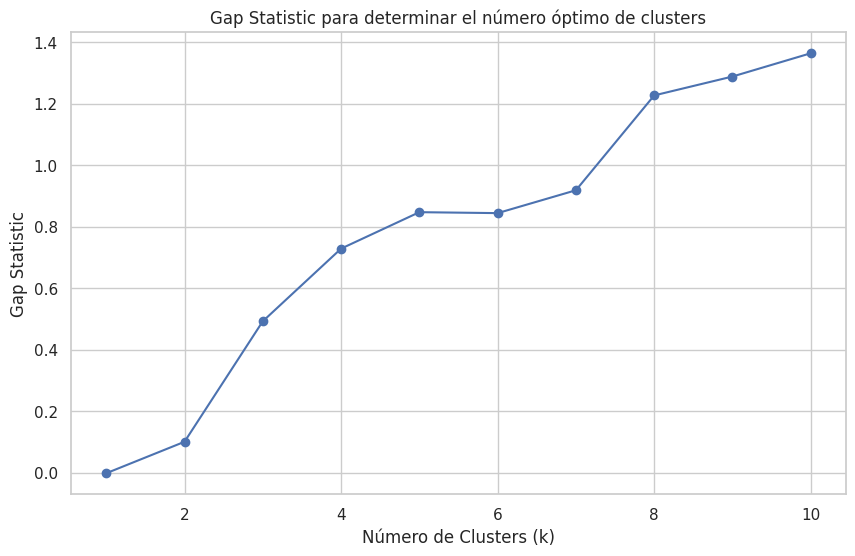

In [ ]:
def calculate_intra_cluster_dispersion(X, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    return kmeans.inertia_

gaps = []
max_k = 10

for k in range(1, max_k + 1):
    # Calculo la inercia real sobre los datos reales
    real_inertia = calculate_intra_cluster_dispersion(X_scaled, k)

    # Calculo la inercia de datos aleatorios con la misma estructura
    inertia_list = []
    for _ in range(100):
        random_data = np.random.normal(loc=np.mean(X_scaled, axis=0), scale=np.std(X_scaled, axis=0), size=X_scaled.shape)
        intra_cluster_dispersion = calculate_intra_cluster_dispersion(random_data, k)
        inertia_list.append(intra_cluster_dispersion)

    reference_inertia = np.mean(inertia_list)

    # Aplico la función de gap
    gap = np.log(reference_inertia) - np.log(real_inertia)
    gaps.append(gap)

# Determinación del número óptimo de clusters
optimal_k = np.argmax(gaps) + 1

print("Número óptimo de clusters según el Gap Statistic:", optimal_k)

# Visualización
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), gaps, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic para determinar el número óptimo de clusters')
plt.grid(True)
plt.show()

Según el método GAP, el número óptimo de clusters es 10. Por lo tanto, aplicamos K-means con 10 clusters.

##K-Means

In [ ]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X_scaled) #Entrenamos el modelo
# El metodo labels_ nos da a que cluster corresponde cada observacion
df_frutas['Cluster KMeans'] = kmeans.labels_


# Obtener las coordenadas de los centroides
centroids = kmeans.cluster_centers_

print(centroids)


[[-0.23297297 -0.19470769 -0.32872727  0.87334587 -3.30408915 -0.57092091
  -0.19406385]
 [ 1.15230325 -0.28656023  0.04202401 -0.10164687 -0.19215314  0.47163484
  -1.17838626]
 [-0.19831011  1.11533684  2.76374929 -0.98396039  0.04566276 -0.261131
  -0.15834727]
 [-0.15100815 -0.28874237 -0.29264069  0.1845804   0.57786544 -0.22023238
   1.12156109]
 [ 1.21135135  0.48012308  0.03727273  0.20307885 -0.65227157 -0.26463143
   0.03106979]
 [-0.1986602   1.09980276  2.76317016  1.39295729 -0.49583652 -0.32308217
  -0.75703853]
 [-0.09988936 -0.1794332  -0.21913876  0.18013862  0.57765108  0.02421445
   2.36053849]
 [-0.23042273 -0.27952663 -0.13426573 -0.74635118  0.2140768   0.38011524
   0.096523  ]
 [ 0.26846847  0.20471795  0.02060606  2.11237076  0.40834259  0.84768235
   2.24935318]
 [ 0.34369369  0.18861538  0.04363636  1.69625094  0.41243607  0.80254472
  -0.33795681]]


Calculamos el promedio de cada columna para cada cluster

In [ ]:
numeric_columns = df_frutas.select_dtypes(include=['float64', 'int64', "int32"])
cluster_means = numeric_columns.groupby(df_frutas['Cluster KMeans']).mean()
cluster_means.head(10)


,Nitrogeno,Fosforo,Potasio,Temperatura,Humedad,pH,Lluvia,Cluster KMeans
Cluster KMeans,,,,,,,,
0,20.070000,27.180000,29.920000,31.208770,50.156573,5.766373,94.704515,0.0
1,96.952830,19.716981,50.311321,25.634656,85.598411,6.506774,51.321815,1.0
2,21.993789,133.621118,200.006211,20.590397,88.306897,5.986379,96.278676,2.0
3,24.619048,19.539683,31.904762,27.271041,94.368153,6.015424,152.688933,3.0
4,100.230000,82.010000,50.050000,27.376798,80.358123,5.983893,104.626980,4.0
5,21.974359,132.358974,199.974359,34.179432,82.139761,5.942383,69.892155,5.0
6,27.456140,28.421053,35.947368,27.245647,94.365711,6.189025,207.295212,6.0
7,20.211538,20.288462,40.615385,21.948829,90.224964,6.441779,107.511743,7.0
8,47.900000,59.633333,49.133333,38.292378,92.437457,6.773835,202.394868,8.0


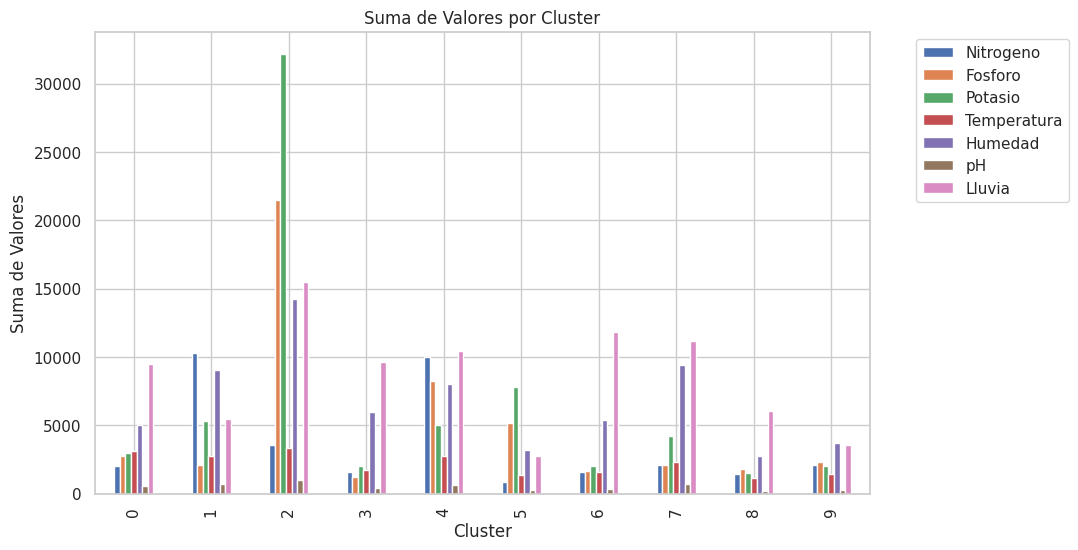

In [ ]:
numeric_columns = df_frutas.select_dtypes(include=['float64', 'int64'])
cluster_sums = numeric_columns.groupby(df_frutas['Cluster KMeans']).sum()

cluster_sums.plot(kind='bar', figsize=(10, 6))

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Suma de Valores por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Suma de Valores')

plt.show()


En el gráfico proporcionado, se visualiza la **suma de valores** para las distintas variables numéricas (Nitrógeno, Fósforo, Potasio, Temperatura, Humedad, pH, y Lluvia) agrupadas por los **clusters** obtenidos mediante el algoritmo KMeans.

### Interpretación:
1. **Distribución desigual**: Los valores acumulados de las variables varían significativamente entre los clusters. Esto indica que cada cluster presenta una combinación particular de valores para las diferentes variables, lo que sugiere que cada cluster puede estar capturando diferentes patrones o comportamientos en los datos.

2. **Ciertos clusters dominan en algunas variables**: Algunos clusters destacan por tener las sumas más elevadas en algunas variables, especialmente en **Potasio** o **Lluvia**. Estos valores sugieren que en esos clusters hay un gran predominio de estos elementos, lo que podría estar relacionado con ciertas condiciones específicas de las observaciones en esos grupos.

3. **Lluvia y Humedad en otros clusters**: Las variables **Lluvia** y **Humedad** parecen tener una distribución más presente en varios clusters, mostrando que hay clusters donde la variación de estos factores es significativa. Esto puede indicar que los grupos diferenciados reflejan diferentes zonas o épocas con niveles específicos de precipitaciones y humedad.

El gráfico muestra que el algoritmo de clustering KMeans ha agrupado los datos de manera que cada cluster tiene características específicas en términos de la suma de estas variables. Esta segmentación es buena para entender patrones en los datos, como áreas con mayor fertilidad (en términos de nitrógeno, fósforo, y potasio) o zonas con diferentes niveles de lluvia y humedad.

### Gráfico 3D

Decidimos elegir fósforo, nitrógeno y potasio, ya que son tres atributos que tienen una relación directa en el análisis de suelos o fertilizantes. Sin embargo, también podríamos haber elegido temperatura, humedad y lluvia para observar la influencia de las condiciones climáticas sobre los clústeres. Alternativamente, podríamos seleccionar lluvia, potasio y humedad para analizar cómo las condiciones del agua y la humedad afectan el contenido de potasio en los clústeres.

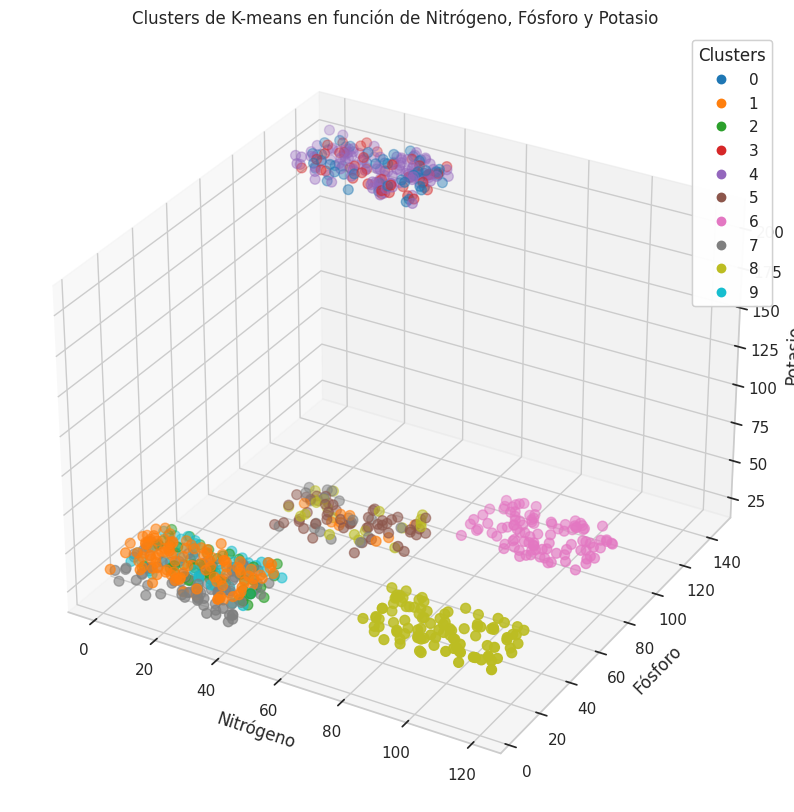

In [ ]:
kmeans = KMeans(n_clusters=optimal_k)
df_frutas['Cluster'] = kmeans.fit_predict(X_scaled)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_frutas['Nitrogeno'], df_frutas['Fosforo'], df_frutas['Potasio'],
                     c=df_frutas['Cluster'], cmap='tab10', s=50)

ax.set_xlabel('Nitrógeno')
ax.set_ylabel('Fósforo')
ax.set_zlabel('Potasio')
ax.set_title('Clusters de K-means en función de Nitrógeno, Fósforo y Potasio')

legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()


### Observaciones
- El gráfico muestra una clara separación de los datos en varios grupos bien diferenciados, lo que indica que el algoritmo de K-Means ha encontrado patrones significativos basados en la composición de Nitrógeno, Fósforo y Potasio.
- Algunos clusters tienen una mayor dispersión interna, mientras que otros están más concentrados, lo que puede implicar que las muestras dentro de esos clusters tienen características más homogéneas.



#Clustering jerarquico


In [ ]:
Z = linkage(X_scaled, "ward")

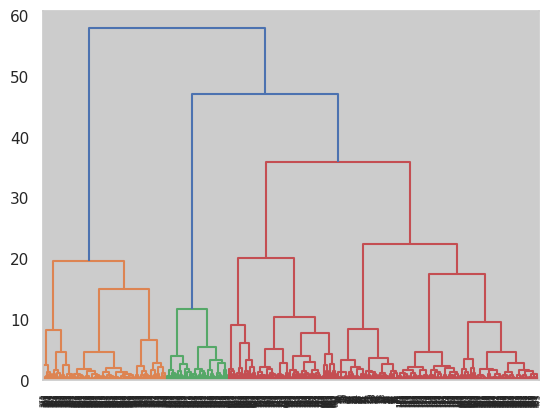

In [ ]:
dendrogram(Z)
plt.show()

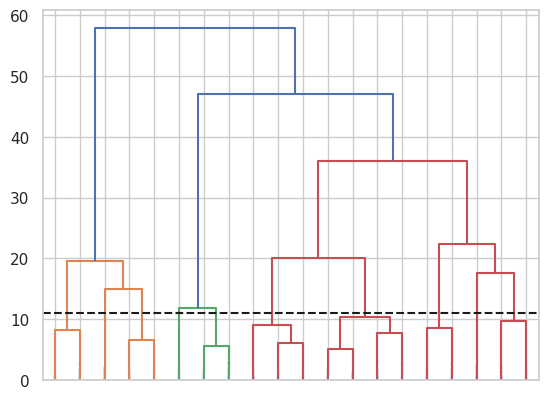

In [ ]:
dendrogram(Z,  truncate_mode = 'lastp', p = 20, show_leaf_counts = False, show_contracted = True)
plt.axhline(y=11, c='k', linestyle='dashed')
plt.show()

En el dendrograma se observa que los datos se agrupan en varios niveles jerárquicos. Al cortar el gráfico a la altura de la línea discontinua, se identifican **cuatro clústeres principales**: dos grupos claramente diferenciados a la izquierda y dos a la derecha. Los grupos de la izquierda se fusionan a una altura menor, lo que indica que son más similares entre sí en comparación con los grupos de la derecha, que se unen a alturas más altas, reflejando mayor disimilitud. La mayor separación en la parte superior del dendrograma indica que estos clústeres son distintos y bien definidos, lo que sugiere una estructura de datos con diferenciación clara entre los grupos.

Al analizar este gráfico, se puede observar que los mayores saltos podrían comenzar a partir de 'y=11', lo que sugiere que, si contamos, obtendríamos un valor de 10 clusters.

### Silhouette

Silhouette Score para 2 clusters: 0.3812408872023245
Silhouette Score para 3 clusters: 0.4610477062703424
Silhouette Score para 4 clusters: 0.4391540912969717
Silhouette Score para 5 clusters: 0.4106696912211278
Silhouette Score para 6 clusters: 0.43965213558199906
Silhouette Score para 7 clusters: 0.42925315144447146
Silhouette Score para 8 clusters: 0.45509430441603727
Silhouette Score para 9 clusters: 0.470909111432541
Silhouette Score para 10 clusters: 0.4516400447310583
Silhouette Score para 11 clusters: 0.4252745184746378
Silhouette Score para 12 clusters: 0.42999881272598545


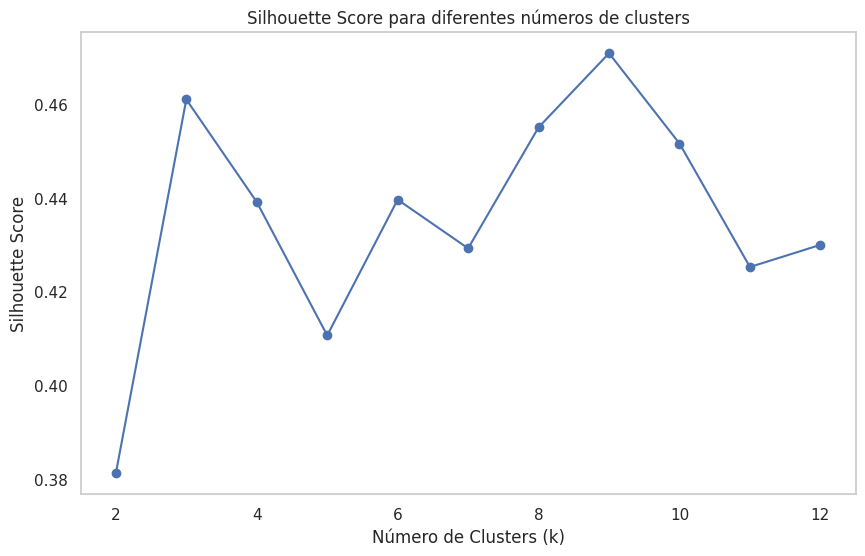

In [ ]:
max_k = 12
silhouette_scores = []
k_values = range(2, max_k + 1)

# Calculamos el Silhouette Score para cada k
for k in k_values:
    clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
    cluster_assignments = clustering.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_assignments)
    silhouette_scores.append(silhouette_avg)
    print(f"Silhouette Score para {k} clusters: {silhouette_avg}")

# Visualización de los resultados
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para diferentes números de clusters')
plt.grid()
plt.show()

## GAP

In [ ]:
def calculate_intra_cluster_dispersion(X, k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    return kmeans.inertia_

In [ ]:
gaps = []
max_k = 10
for k in range(1, max_k + 1):
    # Calculo la inercia real sobre mis datos reales
    real_inertia = calculate_intra_cluster_dispersion(X_scaled, k)
    #Calculo al inercia de datos aleatorios con la mismsa estrucutra que mis datos originales
    inertia_list = []
    for _ in range(10):
      random_data = np.random.rand(*X_scaled.shape)
      intra_cluster_dispersion = calculate_intra_cluster_dispersion(random_data, k)
      inertia_list.append(intra_cluster_dispersion)

    reference_inertia = np.mean(inertia_list)

    #Aplico la funcion de gap
    gap = np.log(reference_inertia) - np.log(real_inertia)
    gaps.append(gap)


optimal_k = np.argmax(gaps) + 1
print("Número óptimo de clusters según el Gap Statistic:", optimal_k)


Número óptimo de clusters según el Gap Statistic: 10


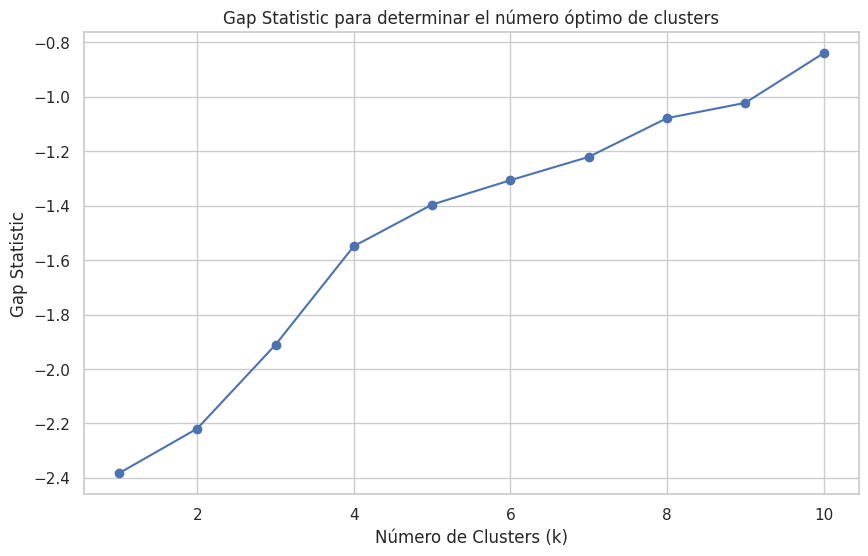

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), gaps, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic para determinar el número óptimo de clusters')
plt.show()

El análisis del Silhouette Score sugiere que el número óptimo de clusters se encuentra entre 8 y 9, donde se observan los valores más altos de cohesión y separación. Sin embargo, el método GAP indica que el número óptimo de clusters es 10. Esto sugiere que, aunque el Silhouette Score muestra que 9 clusters podrían ser ideales en términos de calidad de agrupación, el método GAP podría estar considerando otros factores que justifican la elección de 10 clusters para capturar la estructura global de los datos. Por lo tanto, se podría optar por 10 clusters, equilibrando la calidad de la agrupación con la recomendación del método GAP.